In [79]:
import cv2 as cv
import numpy as np
import math
from skimage.exposure import rescale_intensity
from matplotlib.colors import NoNorm
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab import files
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


LOAD ORIGIN IMAGE

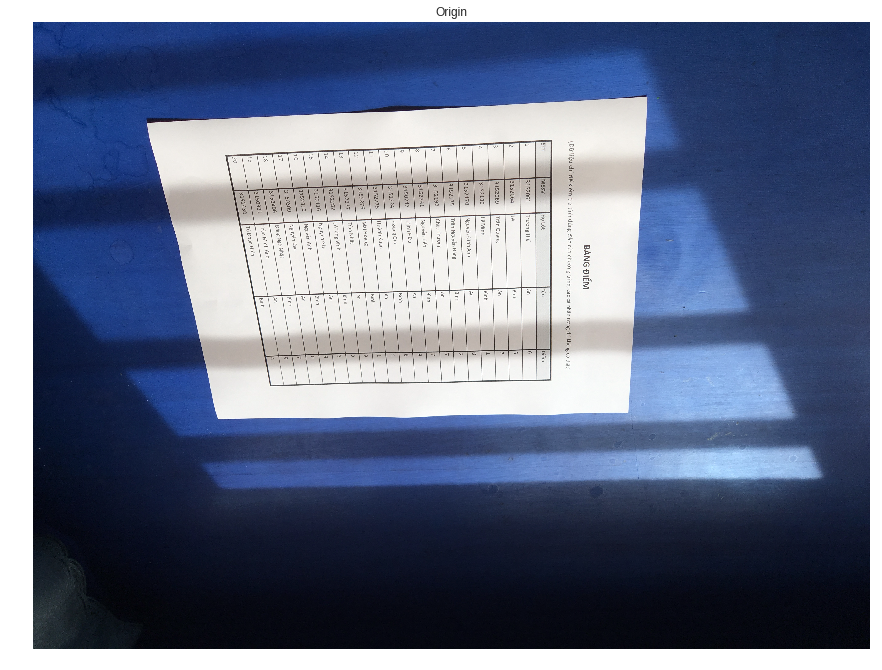

In [80]:
def showImg(img, name):
  plt.figure(figsize=(15,15))
  plt.imshow(img, cmap='gray')
  plt.axis('off')
  plt.title(name)
  plt.show()
image = cv.imread("/content/gdrive/My Drive/Colab Notebooks/img/assignment.jpg")
image_test = cv.imread("/content/gdrive/My Drive/Colab Notebooks/img/IMG_0907.JPG")
image_origin = cv.imread("/content/gdrive/My Drive/Colab Notebooks/img/Original Table-1.jpg")
image = cv.cvtColor(image,cv.COLOR_BGR2RGB)

M = np.array([])

showImg(image_test, "Origin")

## PERSPECTIVE TRANSFORM
PROJECTIVE MATRIX

![PROJECTIVE MATRIX](http://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/EPSRC_SSAZ/img136.gif)

http://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/EPSRC_SSAZ/node11.html


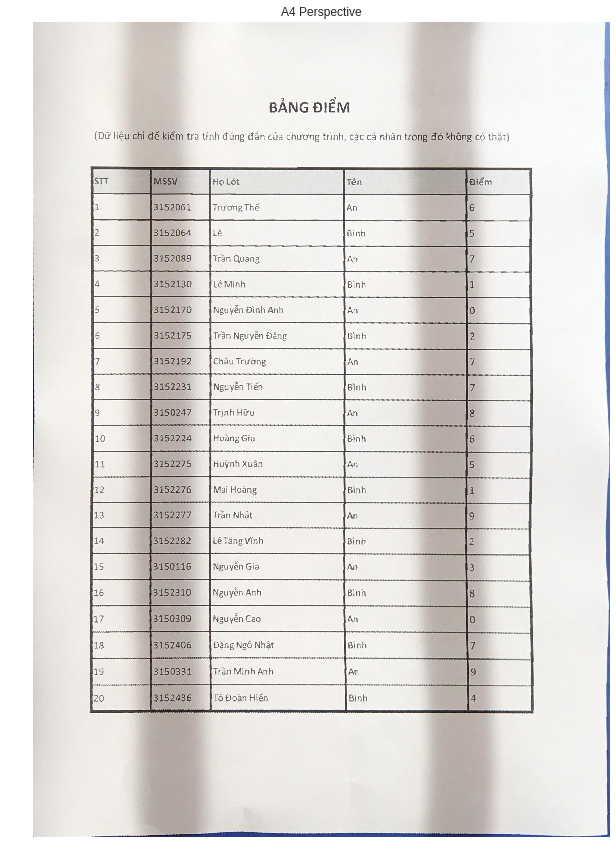

In [81]:
def warpPerspective(img, mat, size):
  warp = np.zeros((size[1], size[0], 3), dtype = np.uint8)
  M1 = np.linalg.inv(mat)
  for row in range(size[1]):
    for col in range(size[0]):
      npx = np.array([col, row, 1])
      p = np.matmul(M1, npx)
      r = int(round(p[1]/p[2]))
      c = int(round(p[0]/p[2]))
      warp[row, col] = img[r, c]
  return warp
def transform(image, rect):
    (tl, tr, br, bl) = rect

    heightA     = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB     = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    Height   = int(heightA) if int(heightA) > int(heightB) else int(heightB)
    Width    = int(Height * 210 / 297)

    dst = np.array([
        [           0,              0],
        [   Width - 1,              0],
        [   Width - 1,     Height - 1],
        [           0,     Height - 1]], dtype = "float32")
    P = np.array([
        [      -tl[0],      -tl[1],         -1,          0,          0,      0, tl[0]*dst[0][0], tl[1]*dst[0][0],    dst[0][0]],
        [           0,           0,          0,     -tl[0],     -tl[1],     -1, tl[0]*dst[0][1], tl[1]*dst[0][1],    dst[0][1]],
        [      -tr[0],      -tr[1],         -1,          0,          0,      0, tr[0]*dst[1][0], tr[1]*dst[1][0],    dst[1][0]],
        [           0,           0,          0,     -tr[0],     -tr[1],     -1, tr[0]*dst[1][1], tr[1]*dst[1][1],    dst[1][1]],
        [      -br[0],      -br[1],         -1,          0,          0,      0, br[0]*dst[2][0], br[1]*dst[2][0],    dst[2][0]],
        [           0,           0,          0,     -br[0],     -br[1],     -1, br[0]*dst[2][1], br[1]*dst[2][1],    dst[2][1]],
        [      -bl[0],      -bl[1],         -1,          0,          0,      0, bl[0]*dst[3][0], bl[1]*dst[3][0],    dst[3][0]],
        [           0,           0,          0,     -bl[0],     -bl[1],     -1, bl[0]*dst[3][1], bl[1]*dst[3][1],    dst[3][1]],
        [           0,           0,          0,          0,          0,      0,               0,               0,           1]], dtype = "float32")
    arr_01 = np.array([
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1]], dtype = "float32")
    P_1 = np.linalg.inv(P)
    H = P_1.dot(arr_01)
    M = np.array([
        [           H[0][0],              H[1][0],            H[2][0]],
        [           H[3][0],              H[4][0],            H[5][0]],
        [           H[6][0],              H[7][0],            H[8][0]]], dtype = "float32")
    warped = warpPerspective(image, M, (Width, Height))
    return warped

# pts = np.array([(915, 2375),(1406, 1677),(2495, 2402),(2260, 3207)], dtype = "float32")
pts = np.array([(2954, 367),(2868, 1897),(887, 1922),(548, 495)], dtype = "float32")
warped = transform(image_test, pts)
showImg(warped, "A4 Perspective")

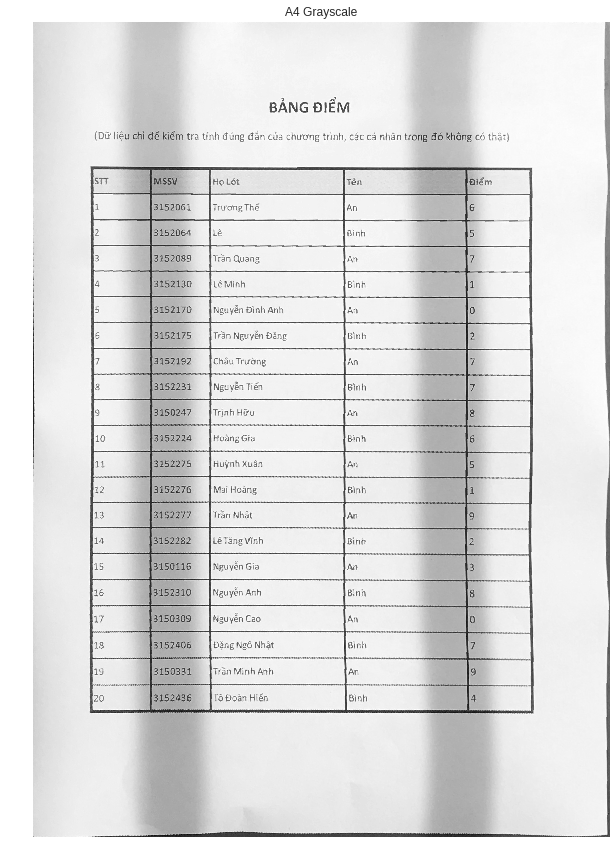

In [82]:
grayscale = cv.cvtColor(warped,cv.COLOR_RGB2GRAY)
plt.figure(figsize=(15,15))
plt.imshow(grayscale, cmap=plt.cm.gray)
plt.axis('off')
plt.title("A4 Grayscale")
plt.show()


HISTOGRAM EQUALIZATION

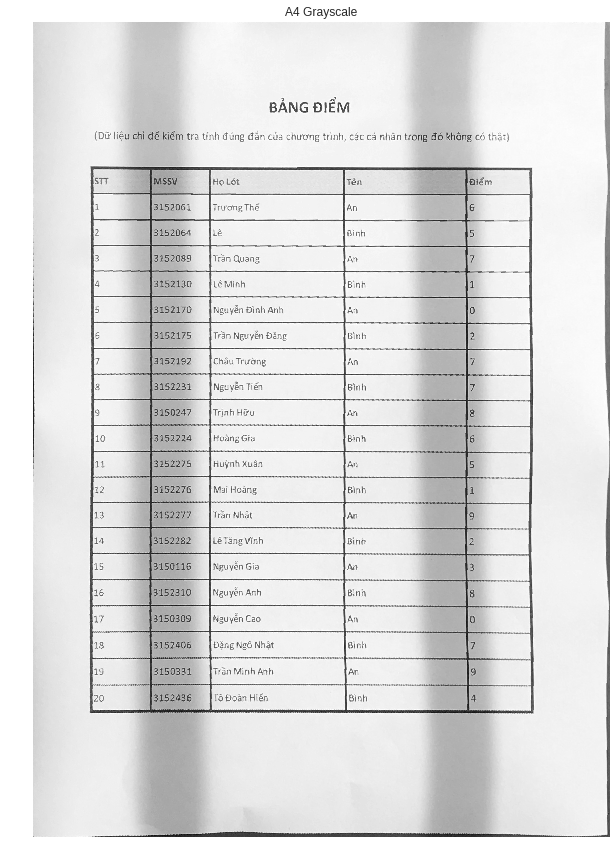

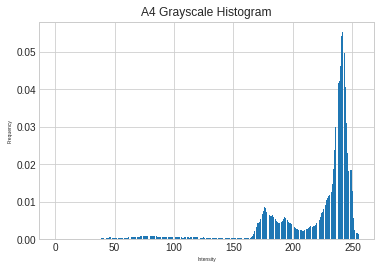

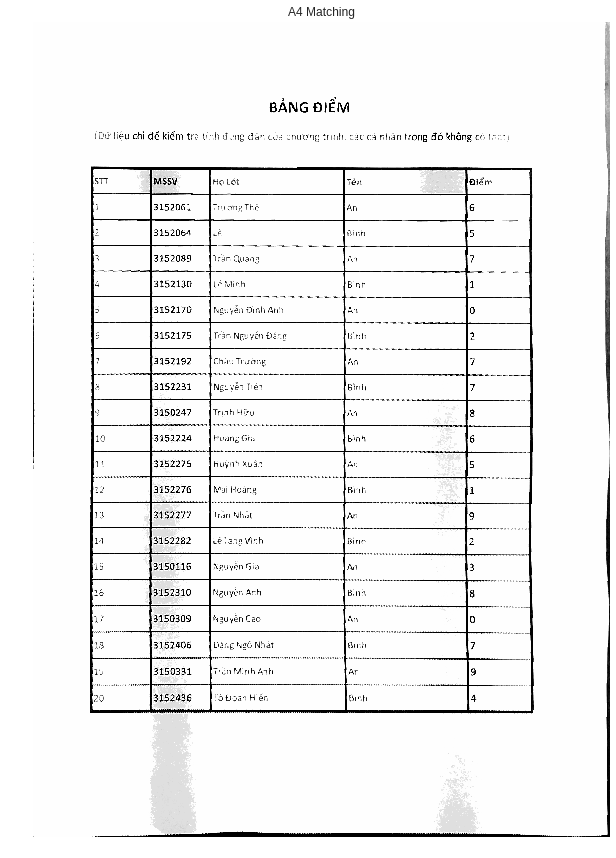

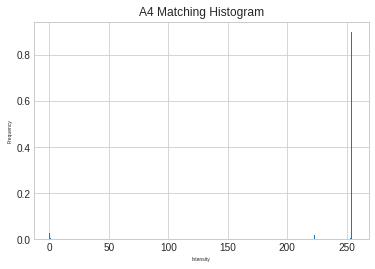

In [106]:
def create_histogram(img):
    assert len(img.shape) == 2
    H,W = img.shape
    histogram = np.zeros(shape=(256,), dtype = int)
    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
            histogram[img[row,col]] += 1
    return histogram/(H*W)

def visualize_histogram(histogram, name):
    index = np.arange(len(histogram))
    plt.bar(index,histogram)
    plt.xlabel('Intensity', fontsize = 5)
    plt.ylabel('Frequency', fontsize = 5)
    plt.title(name)
    plt.show()

def histogram_equalization(image):
    oldshape = image.shape
    # Stretch anh thanh ma tran 1 chieu
    image = image.ravel()
    s_values, bin_idx, s_counts = np.unique(image, return_inverse=True, return_counts=True)
    t_values = np.arange(0,256,1, dtype = np.uint8)
    t_counts = np.ones((256), dtype = np.uint8)
    # Tao mang tich luy tan suat cac gia tri
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]
    #Map cac gia tri tan suat tich luy tu anh nguon sang anh template de lay gia tri muc sang moi
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return interp_t_values[bin_idx].reshape(oldshape)

def histogram_matching(image,template):
    oldshape = image.shape
    # Stretch anh thanh ma tran 1 chieu
    image = image.ravel()
    template = template.ravel()
    s_values, bin_idx, s_counts = np.unique(image, return_inverse=True, return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)
    # Tao mang tich luy tan suat cac gia tri
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]
    #Map cac gia tri tan suat tich luy tu anh nguon sang anh template de lay gia tri muc sang moi
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return interp_t_values[bin_idx].reshape(oldshape)  

# grayscale = cv.cvtColor(warped,cv.COLOR_RGB2GRAY)
# showImg(grayscale,"A4 Grayscale")
# imghistogram   = create_histogram(grayscale)
# visualize_histogram(imghistogram, 'A4 Grayscale Histogram')

# equalization = histogram_equalization(grayscale).astype(int)
# showImg(equalization,"A4 Equalization")
# imghistogram   = create_histogram(equalization)
# visualize_histogram(imghistogram, 'A4 Equalization Histogram')
grayscale = cv.cvtColor(warped,cv.COLOR_RGB2GRAY)
showImg(grayscale,"A4 Grayscale")
imghistogram   = create_histogram(grayscale)
visualize_histogram(imghistogram, 'A4 Grayscale Histogram')

equalization = histogram_matching(grayscale,cv.cvtColor(image_origin,cv.COLOR_BGR2GRAY)).astype(int)
showImg(equalization,"A4 Matching")
imghistogram   = create_histogram(equalization)
visualize_histogram(imghistogram, 'A4 Matching Histogram')



## MORPHOLOGICAL
EROSION

![EROSION](https://homepages.inf.ed.ac.uk/rbf/HIPR2/figs/erodbin.gif)

https://homepages.inf.ed.ac.uk/rbf/HIPR2/erode.htm

DILATION

![EROSION](https://homepages.inf.ed.ac.uk/rbf/HIPR2/figs/diltbin.gif)

https://homepages.inf.ed.ac.uk/rbf/HIPR2/dilate.htm

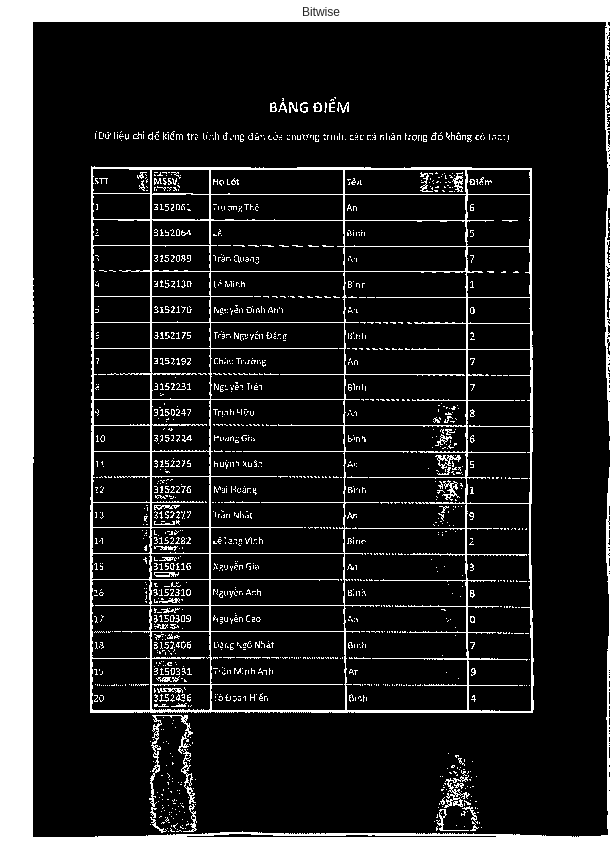

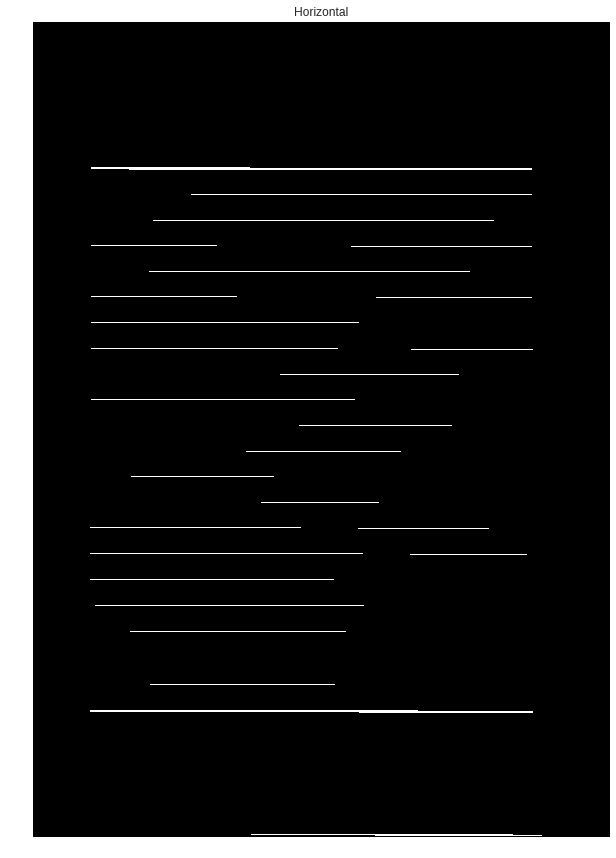

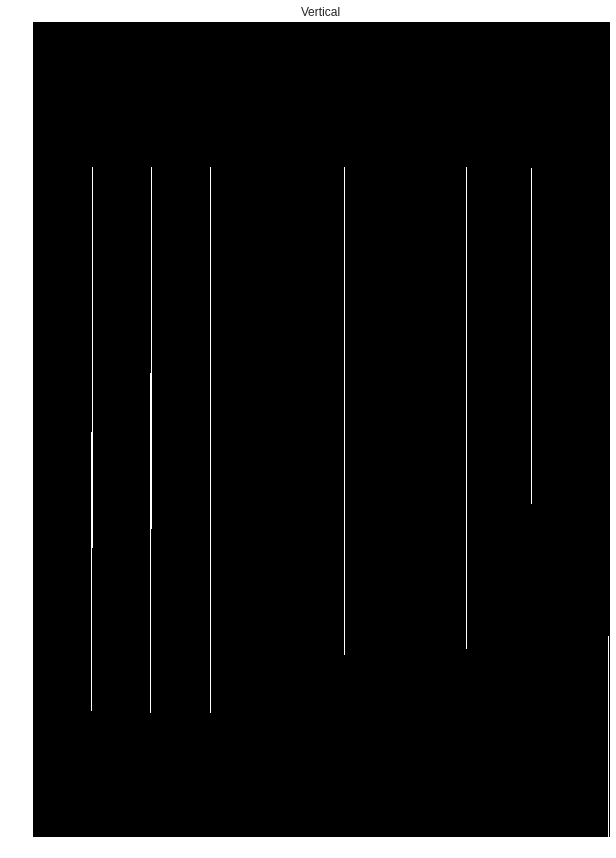

In [107]:
def idx_check(index):
  if index < 0:
    return 0
  else:
    return index

def dilation(binary_img_matrix, structuring_element):
  binary_img_matrix = np.asarray(binary_img_matrix)
  structuring_element = np.asarray(structuring_element)
  ste_shp = structuring_element.shape
  dilated_img = np.zeros((binary_img_matrix.shape[0], binary_img_matrix.shape[1]))
  ste_origin = ((structuring_element.shape[0]-1)//2, (structuring_element.shape[1]-1)//2)
  for i in range(len(binary_img_matrix)):
    for j in range(len(binary_img_matrix[0])):
      overlap = binary_img_matrix[idx_check(i - ste_origin[0]):i + (ste_shp[0] - ste_origin[0]), idx_check(j - ste_origin[1]):j + (ste_shp[1] - ste_origin[1])]
      shp = overlap.shape
      
      ste_first_row_idx = int(np.fabs(i - ste_origin[0])) if i - ste_origin[0] < 0 else 0
      ste_first_col_idx = int(np.fabs(j - ste_origin[1])) if j - ste_origin[1] < 0 else 0
      ste_last_row_idx = ste_shp[0] - 1 - (i + (ste_shp[0] - ste_origin[0]) - binary_img_matrix.shape[0]) if i + (ste_shp[0] - ste_origin[0]) > binary_img_matrix.shape[0] else ste_shp[0]-1
      ste_last_col_idx = ste_shp[1] - 1 - (j + (ste_shp[1] - ste_origin[1]) - binary_img_matrix.shape[1]) if j + (ste_shp[1] - ste_origin[1]) > binary_img_matrix.shape[1] else ste_shp[1]-1

      if shp[0] != 0 and shp[1] != 0 and np.logical_and(structuring_element[ste_first_row_idx:ste_last_row_idx+1, ste_first_col_idx:ste_last_col_idx+1], overlap).any():
        dilated_img[i, j] = 255
  return dilated_img.astype(np.uint8)

def erosion(binary_img_matrix, structuring_element):
  binary_img_matrix = np.asarray(binary_img_matrix)
  structuring_element = np.asarray(structuring_element)
  ste_shp = structuring_element.shape
  eroded_img = np.zeros((binary_img_matrix.shape[0], binary_img_matrix.shape[1]))
  ste_origin = (int(np.ceil((structuring_element.shape[0] - 1) / 2.0)), int(np.ceil((structuring_element.shape[1] - 1) / 2.0)))
  for i in range(len(binary_img_matrix)):
    for j in range(len(binary_img_matrix[0])):
      overlap = binary_img_matrix[idx_check(i - ste_origin[0]):i + (ste_shp[0] - ste_origin[0]), idx_check(j - ste_origin[1]):j + (ste_shp[1] - ste_origin[1])]
      shp = overlap.shape
      ste_first_row_idx = int(np.fabs(i - ste_origin[0])) if i - ste_origin[0] < 0 else 0
      ste_first_col_idx = int(np.fabs(j - ste_origin[1])) if j - ste_origin[1] < 0 else 0
      ste_last_row_idx = ste_shp[0] - 1 - (i + (ste_shp[0] - ste_origin[0]) - binary_img_matrix.shape[0]) if i + (ste_shp[0] - ste_origin[0]) > binary_img_matrix.shape[0] else ste_shp[0]-1
      ste_last_col_idx = ste_shp[1] - 1 - (j + (ste_shp[1] - ste_origin[1]) - binary_img_matrix.shape[1]) if j + (ste_shp[1] - ste_origin[1]) > binary_img_matrix.shape[1] else ste_shp[1]-1
      if shp[0] != 0 and shp[1] != 0 and np.array_equal(np.logical_and(overlap, structuring_element[ste_first_row_idx:ste_last_row_idx+1, ste_first_col_idx:ste_last_col_idx+1]),structuring_element[ste_first_row_idx:ste_last_row_idx+1,ste_first_col_idx:ste_last_col_idx+1]):
        eroded_img[i, j] = 255
  return eroded_img.astype(np.uint8)

gray = cv.bitwise_not(equalization).astype(np.uint8)
bw   = cv.adaptiveThreshold(gray, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 15, -2)

showImg(bw,"Bitwise")


horizontal = np.copy(bw)
vertical   = np.copy(bw)

# Lay cac line ngang horizontal
cols = horizontal.shape[1]
horizontal_size = cols // 5

horizontalStructure = cv.getStructuringElement(cv.MORPH_RECT, (horizontal_size, 1))

horizontal = erosion(horizontal, horizontalStructure)
horizontal = dilation(horizontal, horizontalStructure)

showImg(horizontal, "Horizontal")

# Lay cac line doc vertical
rows = vertical.shape[0]
vertical_size = rows // 3

verticalStructure =  cv.getStructuringElement(cv.MORPH_RECT, (1, vertical_size))

vertical = erosion(vertical, verticalStructure)
vertical = dilation(vertical, verticalStructure)

showImg(vertical, "Vertical")

HIGH PASS FILTER

In [0]:
# def normalize(image):
#     image   = np.abs(image)
#     image   = image - np.min(image)
#     image   = 255*(image/np.max(image))
#     image   = image.astype(np.uint8)
#     return image

# def gamma(image,a,b,gamma=1.0):
#     image = image.astype(np.float64)
#     image = a*np.power(image,gamma) + b
#     image = np.clip(image,0,255)
#     image = image.astype(np.uint8)
#     return image

# def meshgrid(M):
#     L = -M//2
#     R = M//2 
#     u = np.arange(L,R)
#     u = np.tile(u,(M,1))
#     v = np.arange(L,R)
#     v = np.repeat(v, M) 
#     v = np.reshape(v, (M,M))
#     return u,v

# def GaussianHightPassFilter(M, r0):
#     u,v = meshgrid(M)
#     r = np.sqrt(u*u+v*v)
#     H = 1-math.e**(-np.power(r/(math.sqrt(2)*r0),2))
#     return H

# Key = 0
# M   = 2048
# r0  = 250
# BW  = 2
# original_shape = horizontal.shape

# image_F         = np.fft.fft2(horizontal,(M,M))
# image_F_shift   = np.fft.ifftshift(image_F)


# image_F_gray    = normalize(image_F)
# image_F_gray    = gamma(image_F_gray, 120.0, 50, 0.1)                  
# image_F_shift_gray = normalize(image_F_shift)
# image_F_shift_gray = gamma(image_F_shift_gray, 120, 50, 0.1)

# showImg(image_F_shift_gray,"FFT")
# H = GaussianHightPassFilter(M,r0)

# plt.figure(figsize=(15,15))
# plt.imshow(H)
# plt.colorbar()
# plt.show()

# FH_image = image_F_shift*H
# FH_image_ishift = np.fft.ifftshift(FH_image)
# filtered_image  = np.fft.ifft2(FH_image_ishift,(M,M))
# filtered_image_real = filtered_image.real
# filtered_image_real = normalize(filtered_image_real)
# filtered_image_real = filtered_image_real[0:original_shape[0],0:original_shape[1]]

# showImg(filtered_image_real,"Gaussian Hight Pass Filtered")

CANNY EDGE

In [0]:
# denoise = cv.fastNlMeansDenoising(equalization)
# plt.figure(figsize=(15,15))
# plt.imshow(denoise, cmap=plt.cm.gray)
# plt.axis('off')
# plt.title("A4 Canny Edge")
# plt.show()
# print(grayscale.shape)
# print(equalization.shape)
# edges = cv.Canny(equalization   .astype(np.uint8), 120, 200, apertureSize = 3)
# plt.figure(figsize=(15,15))
# plt.imshow(edges, cmap=plt.cm.gray)
# plt.axis('off')
# plt.title("A4 Canny Edge")
# plt.show()

HOUGH LINE DETECTION

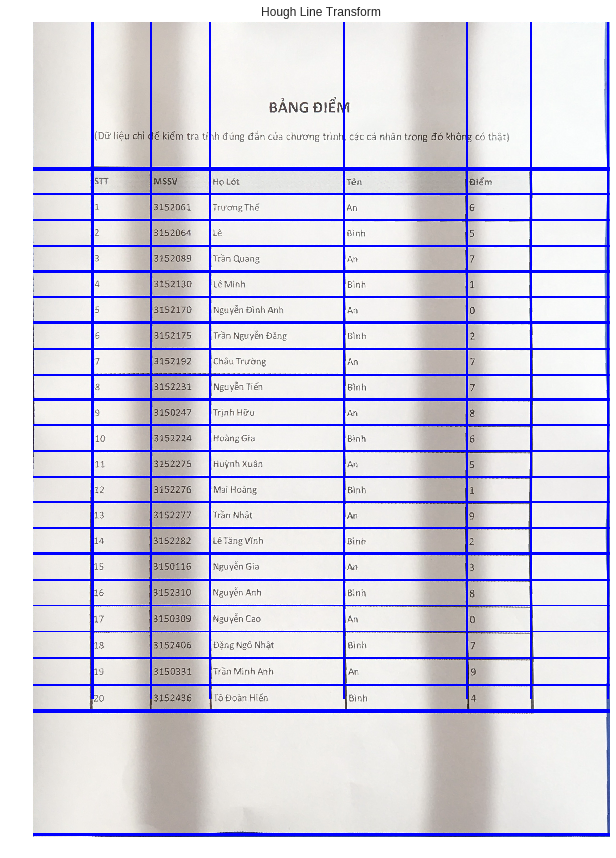

In [108]:
eps = 2000

theta_eps = 0.01


def hough_line_transform(img, angle_step=1, lines_are_white=True, value_threshold=20, line_threshold=10, detect_horizontal = True):
    # Thiet lap tap gia tri goc the va do dai phi
    thetas = np.deg2rad(np.array([90-theta_eps,90,90+theta_eps])) if detect_horizontal else np.deg2rad(np.array([0-theta_eps,0,0+theta_eps]))
    width, height = img.shape
    diag_len = int(round(math.sqrt(width * width + height * height)))
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2)

    # Tinh sin cos
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)

    # Tao bang gom vote
    accumulator = np.zeros((2 * diag_len, num_thetas), dtype=np.uint8)
    # Chi lay gia tri diem sang lon hon value_threshold de xet
    are_edges = img > value_threshold if lines_are_white else img < value_threshold
    y_idxs,x_idxs, = np.nonzero(are_edges)

    # Vote tren bang vote
    lines = []
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]

        for t_idx in range(num_thetas):
            # Tinh gia tri theta va phi de vote
            rho = diag_len + int(round(x * cos_t[t_idx] + y * sin_t[t_idx]))
            accumulator[rho, t_idx] += 1
    for rh in range(2 * diag_len):
        for th in range(num_thetas):
            if accumulator[rh, th] > line_threshold:
              lines += [[rh-diag_len,thetas[th]]]
    return accumulator, thetas, rhos, lines

def show_hough_line(img, accumulator, thetas, rhos, save_path=None):
    fig, ax = plt.subplots(1, 2, figsize=(30, 30))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Input image')
    ax[0].axis('image')

    ax[1].imshow(accumulator, cmap='jet', extent=[np.rad2deg(thetas[-1]), np.rad2deg(thetas[0]), rhos[-1], rhos[0]])
    ax[1].set_title('Accumulator')
    ax[1].set_xlabel('angles (degrees)')
    ax[1].set_ylabel('distance (pixels)')
    ax[1].axis('image')

    if save_path is not None: 
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

houghline = warped.copy()
accumulator, thetas, rhos, lines_horizontal = hough_line_transform(horizontal)      
Y_cut = []
X_cut = []
for [rho, theta] in lines_horizontal:
  a   = np.cos(theta)
  b   = np.sin(theta)
  x0  = a*rho
  y0  = b*rho
  x1  = int(x0 + eps*(-b))
  y1  = int(y0 + eps*(a))
  x2  = int(x0 - eps*(-b))
  y2  = int(y0 - eps*(a))
  cv.line(houghline, (x1,y1), (x2,y2), (0,0,255),2)
  Y_cut += [int(y0)]

accumulator, thetas, rhos, lines_vertical = hough_line_transform(vertical,1,True,20,10,False)
for [rho, theta] in lines_vertical:
  a   = np.cos(theta)
  b   = np.sin(theta)
  x0  = a*rho
  y0  = b*rho
  x1  = int(x0 + eps*(-b))
  y1  = int(y0 + eps*(a))
  x2  = int(x0 - eps*(-b))
  y2  = int(y0 - eps*(a))
  cv.line(houghline, (x1,y1), (x2,y2), (0,0,255),2)
  X_cut += [int(x0)]


showImg(houghline,"Hough Line Transform")

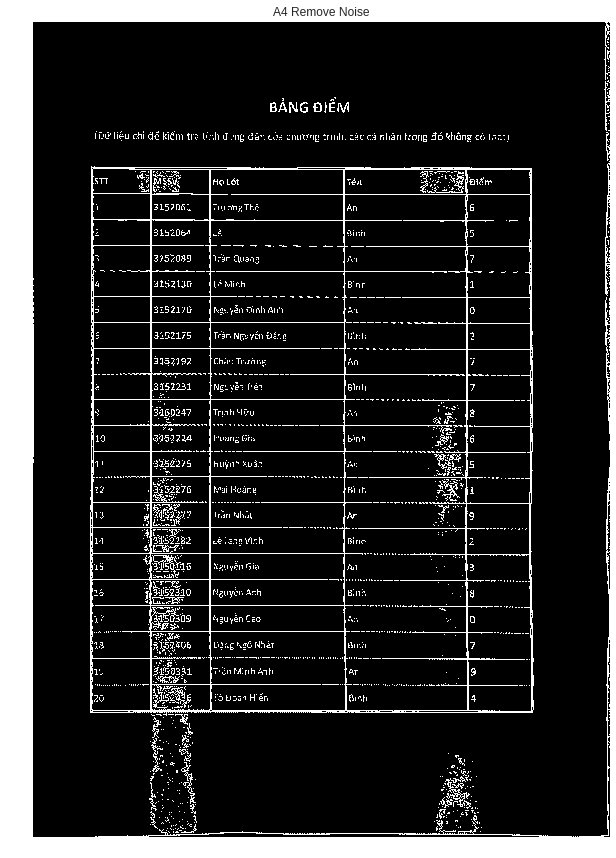

In [109]:
noise_eps = 1
kernel = np.ones((1, noise_eps), np.uint8)
bw   = cv.adaptiveThreshold(gray, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 7, -2)
denoise = bw.copy()
denoise = erosion(denoise, kernel)
kernel = np.ones((noise_eps, 1), np.uint8)
denoise = erosion(denoise, kernel)
denoise = dilation(denoise, kernel)
showImg(denoise,"A4 Remove Noise")

# noise_eps = 2
# kernel = np.ones((noise_eps, noise_eps), np.uint8)
# bw   = cv.adaptiveThreshold(gray, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 7, -2)
# denoise = bw.copy()
# denoise = erosion(denoise, kernel)
# denoise = dilation(denoise, kernel)
# kernel = np.ones((noise_eps, 1), np.uint8)
# denoise = erosion(denoise, kernel)
# denoise = dilation(denoise, kernel)
# showImg(denoise,"A4 Remove Noise")

CUT IMAGE INTO PIECES

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


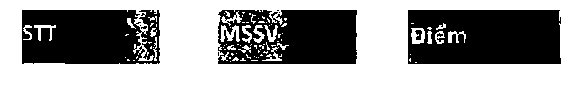

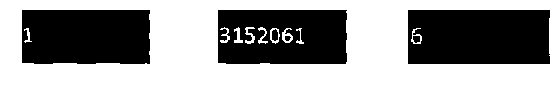

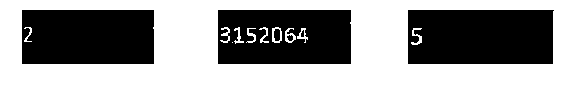

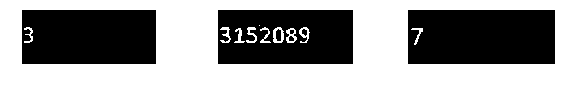

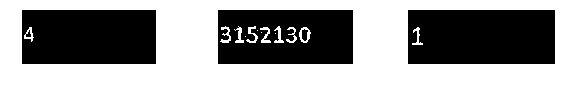

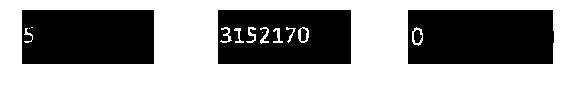

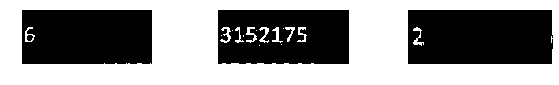

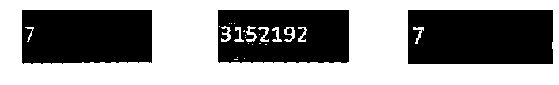

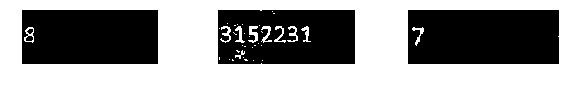

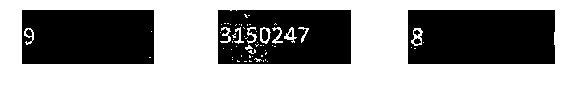

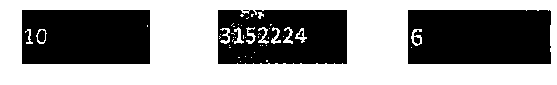

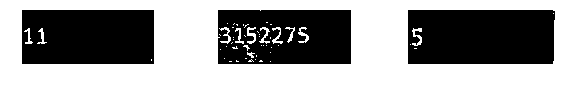

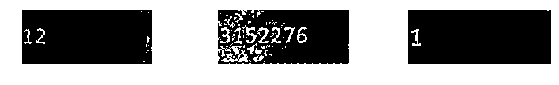

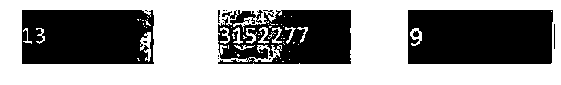

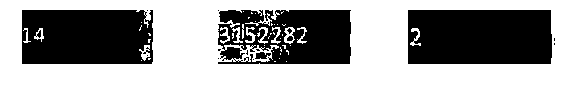

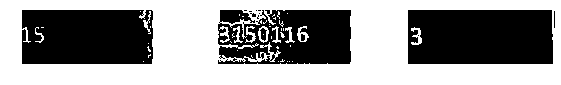

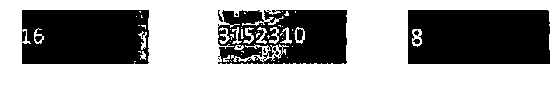

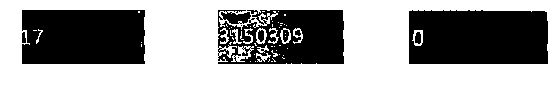

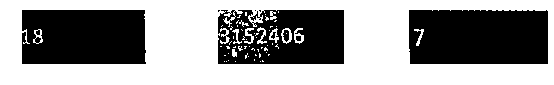

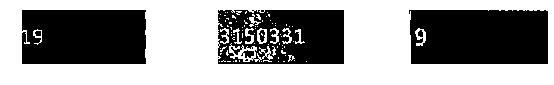

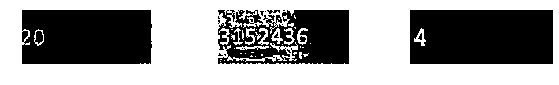

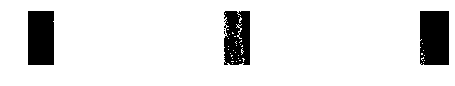

In [110]:
dupline_eps = 5
remove_eps = 4
Y_cut.sort()
X_cut.sort()
Y_cut = [0] + Y_cut
X_cut = [0] + X_cut
horizontal_cut = []
vertical_cut = []

horizontal_det = []
vertical_det = []
inverse = np.subtract(255,equalization)
for idx in range(len(Y_cut))[1:]:
  if abs(Y_cut[idx-1] - Y_cut[idx]) > dupline_eps:
    horizontal_cut += [denoise[Y_cut[idx-1]+remove_eps:Y_cut[idx],:]]
    horizontal_det += [inverse[Y_cut[idx-1]+remove_eps:Y_cut[idx],:]]
for id in range(len(horizontal_cut)):
  vertical_line_cut = []
  vertical_line_det = []
  for idx in range(len(X_cut))[1:]:
    if abs(X_cut[idx-1] - X_cut[idx]) > dupline_eps:
      vertical_line_cut += [horizontal_cut[id][:,X_cut[idx-1]+remove_eps:X_cut[idx]]]
      vertical_line_det += [horizontal_det[id][:,X_cut[idx-1]+remove_eps:X_cut[idx]]]
  vertical_cut += [vertical_line_cut]
  vertical_det += [vertical_line_det]
# vertical_cut = vertical_cut[2:]
# vertical_det = vertical_det[2:]
# number_block = [[line[1],line[2],line[5],line[6],line[7],line[8]] for line in vertical_cut]
# number_block_det = [[line[1],line[2],line[5],line[6],line[7],line[8]] for line in vertical_det]

vertical_cut = vertical_cut[1:]
vertical_det = vertical_det[1:]
number_block = [[line[1],line[2],line[5]] for line in vertical_cut]
number_block_det = [[line[1],line[2],line[5]] for line in vertical_det]
for line in number_block:
  fig, ax = plt.subplots(1, len(line),figsize=(10,1))
  for idx in range(len(line)):
    ax[idx].imshow(line[idx], cmap='gray')
    ax[idx].axis('off')
  
# for line in number_block_det:
#   fig, ax = plt.subplots(1, len(line),figsize=(10,1))
#   for idx in range(len(line)):
#     ax[idx].imshow(line[idx], cmap='gray')
#     ax[idx].axis('off')



## SCAN GRAM

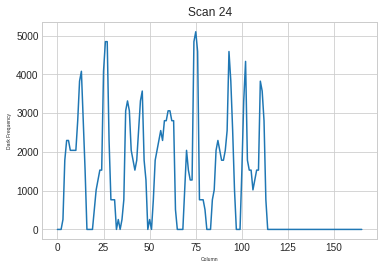

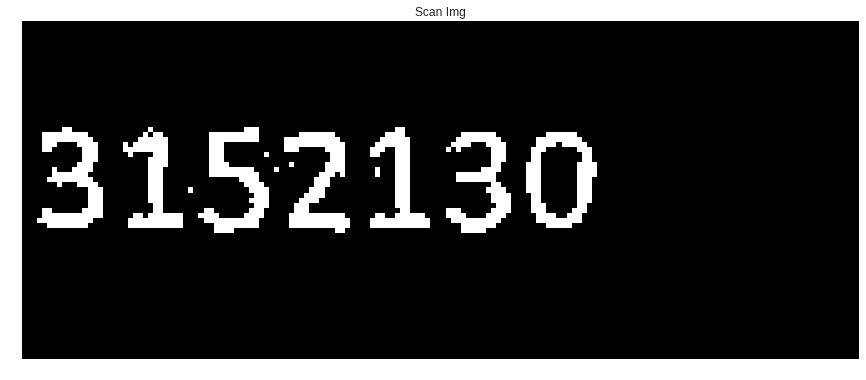

In [124]:
def create_scangram(img):
    assert len(img.shape) == 2
    H,W = img.shape
    scangram = np.zeros(shape=(img.shape[1],1), dtype = int)
    for col in range(img.shape[1]):
      for row in range(img.shape[0]):
        scangram[col] += img[row,col]
    return scangram

def visualize_scangram(scangram, name):
    index = np.arange(scangram.shape[0])
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(index,[x[0] for x in scangram])
    plt.xlabel('Column', fontsize = 5)
    plt.ylabel('Dark Frequency', fontsize = 5)
    plt.title(name)
    plt.show()

scanImg = number_block[4][1]
scan = create_scangram(scanImg)
visualize_scangram(scan,"Scan 24")

showImg(scanImg,"Scan Img")

## CROPPED IMAGE

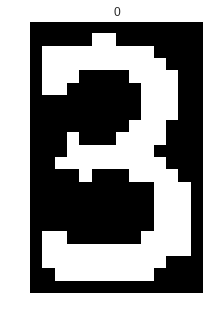

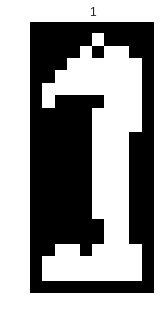

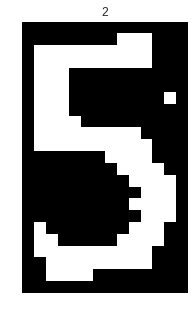

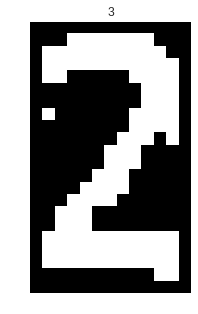

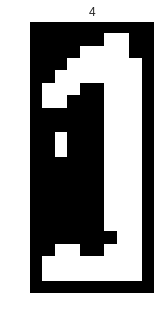

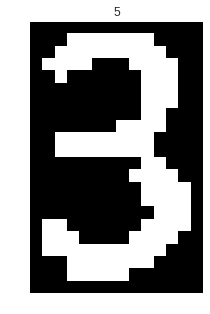

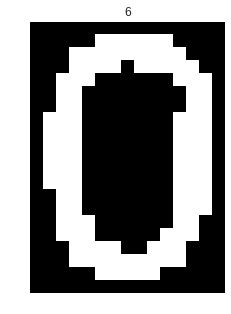

In [126]:
THRESHOLD_PIXELS_COUNT = 950
WIDTH_NUM = 11
SLIDE_BAR = 1
ERA = 0
def detect_vertical_edge(image):
  slice_num = []
  H,W = image.shape
  max = 0
  edge = 0
  x = 0
  while x < W-SLIDE_BAR:
    vertical_slice = image[:, x:x+SLIDE_BAR]
    vertical_slice_pixels_count = vertical_slice.sum()
    
    if vertical_slice_pixels_count > THRESHOLD_PIXELS_COUNT:
      y=x+1
      vertical_slice_next = image[:, y:y+SLIDE_BAR]
      vertical_slice_pixels_next_count =  vertical_slice_next.sum()
      while vertical_slice_pixels_next_count > THRESHOLD_PIXELS_COUNT:
        y +=1
        vertical_slice_next = image[:, y:y+SLIDE_BAR]
        vertical_slice_pixels_next_count =  vertical_slice_next.sum()
      pad = 1
      tempImg = cv.copyMakeBorder(image[4:, x:y],0,0,pad,pad, cv.BORDER_CONSTANT, value=0)
      slice_num += [tempImg]
      x = y
    x += 1
  return slice_num

def detect_horizontal_edge(image):
  slice_num = []
  H,W = image.shape
  max = 0
  edge = 0
  x = 0
  flag = False
  while x < H-SLIDE_BAR:
    vertical_slice = image[x:x+SLIDE_BAR,:]
    vertical_slice_pixels_count = vertical_slice.sum()
    
    if vertical_slice_pixels_count > 0:
      y=x+1
      flag = True
      vertical_slice_next = image[y:y+SLIDE_BAR,:]
      vertical_slice_pixels_next_count =  vertical_slice_next.sum()
      while vertical_slice_pixels_next_count > 0:
        y += 1
        vertical_slice_next = image[y:y+SLIDE_BAR,:]
        vertical_slice_pixels_next_count =  vertical_slice_next.sum()
      pad = 1
      tempImg = cv.copyMakeBorder(image[x:y,:],pad,pad,0,0, cv.BORDER_CONSTANT, value=0)
      return [tempImg]
      x = y
    x += 1
  return []
def showNum(img, name):
  plt.figure(figsize=(5,5))
  plt.imshow(img, cmap='gray')
  plt.axis('off')
  plt.title(name)
  plt.show()

test = detect_vertical_edge(scanImg)
new_test = []
for i in range(len(test)):
  new_test += detect_horizontal_edge(test[i])
  

for i in range(len(new_test)):
  test[i] = test[i]
  showNum(new_test[i],str(i))
test = new_test
      

## Image Moments

In [0]:
def moments(image):
#   Grayscale images
  x, y = np.mgrid[:image.shape[0],:image.shape[1]]
  moments = {}
  moments['mean_x'] = np.sum(x*image)/np.sum(image)
  moments['mean_y'] = np.sum(y*image)/np.sum(image)
  
  moments['mu00'] = np.sum(image)
  moments['mu01'] = np.sum((y-moments['mean_y'])*image)
  moments['mu10'] = np.sum((x-moments['mean_x'])*image)
  moments['mu11'] = np.sum((x-moments['mean_x'])*(y-moments['mean_y'])*image)
  moments['mu02'] = np.sum((y-moments['mean_y'])**2*image) # variance
  moments['mu20'] = np.sum((x-moments['mean_x'])**2*image) # variance
  moments['mu12'] = np.sum((x-moments['mean_x'])*(y-moments['mean_y'])**2*image)
  moments['mu21'] = np.sum((x-moments['mean_x'])**2*(y-moments['mean_y'])*image) 
  return moments

In [0]:
import glob

data_0 = [cv.imread(file) for file in glob.glob('/content/gdrive/My Drive/Colab Notebooks/img/data/0/*.jpg')]
data_1 = [cv.imread(file) for file in glob.glob('/content/gdrive/My Drive/Colab Notebooks/img/data/1/*.jpg')]
data_2 = [cv.imread(file) for file in glob.glob('/content/gdrive/My Drive/Colab Notebooks/img/data/2/*.jpg')]
data_3 = [cv.imread(file) for file in glob.glob('/content/gdrive/My Drive/Colab Notebooks/img/data/3/*.jpg')]
data_4 = [cv.imread(file) for file in glob.glob('/content/gdrive/My Drive/Colab Notebooks/img/data/4/*.jpg')]
data_5 = [cv.imread(file) for file in glob.glob('/content/gdrive/My Drive/Colab Notebooks/img/data/5/*.jpg')]
data_6 = [cv.imread(file) for file in glob.glob('/content/gdrive/My Drive/Colab Notebooks/img/data/6/*.jpg')]
data_7 = [cv.imread(file) for file in glob.glob('/content/gdrive/My Drive/Colab Notebooks/img/data/7/*.jpg')]
data_8 = [cv.imread(file) for file in glob.glob('/content/gdrive/My Drive/Colab Notebooks/img/data/8/*.jpg')]
data_9 = [cv.imread(file) for file in glob.glob('/content/gdrive/My Drive/Colab Notebooks/img/data/9/*.jpg')]

moment_0 = [moments(cv.cvtColor(img,cv.COLOR_BGR2GRAY)) for img in data_0]
moment_1 = [moments(cv.cvtColor(img,cv.COLOR_BGR2GRAY)) for img in data_1]
moment_2 = [moments(cv.cvtColor(img,cv.COLOR_BGR2GRAY)) for img in data_2]
moment_3 = [moments(cv.cvtColor(img,cv.COLOR_BGR2GRAY)) for img in data_3]
moment_4 = [moments(cv.cvtColor(img,cv.COLOR_BGR2GRAY)) for img in data_4]
moment_5 = [moments(cv.cvtColor(img,cv.COLOR_BGR2GRAY)) for img in data_5]
moment_6 = [moments(cv.cvtColor(img,cv.COLOR_BGR2GRAY)) for img in data_6]
moment_7 = [moments(cv.cvtColor(img,cv.COLOR_BGR2GRAY)) for img in data_7]
moment_8 = [moments(cv.cvtColor(img,cv.COLOR_BGR2GRAY)) for img in data_8]
moment_9 = [moments(cv.cvtColor(img,cv.COLOR_BGR2GRAY)) for img in data_9]

moment_data = [moment_0,moment_1,moment_2,moment_3,moment_4,moment_5,moment_6,moment_7,moment_8,moment_9]


##KNN

In [115]:


def euclideanDistance(moment_1,moment_2):
  distances = pow((moment_1['mu00'] - moment_2['mu00']), 2) + pow((moment_1['mu10'] - moment_2['mu10']), 2) + pow((moment_1['mu01'] - moment_2['mu01']), 2)
              
  return math.sqrt(distances)

def getPrediction(image):
  moment_img = moments(image)
  accumulate = []
  for idx in range(10):
    for ins_moment in moment_data[idx]:
      accumulate.append((euclideanDistance(moment_img,ins_moment), idx))
  accumulate.sort(key = lambda x:x[0])
  vote = np.zeros((10), dtype = np.uint8)
  for i in range(3):
    vote[accumulate[i][1]] += 1
  numVote = np.amax(vote)
  if numVote > 1:
    return np.argmax(vote)
  else:
    return accumulate[0][1]

print([getPrediction(test[i]) for i in range(len(test))])

[8, 8, 8, 8, 8, 8, 8, 8]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in ulong_scalars
  after removing the cwd from sys.path.


## CNN - LeNet

In [116]:
from __future__ import division, print_function, absolute_import

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=False)

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [0]:
learning_rate = 0.001
num_steps = 2000
batch_size = 128

num_input = 784 
num_classes = 10 
dropout = 0.25

In [0]:
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    with tf.variable_scope('ConvNet', reuse=reuse):
        x = x_dict['images']
        x = tf.convert_to_tensor(x, dtype=tf.float32)
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        fc1 = tf.contrib.layers.flatten(conv2)

        fc1 = tf.layers.dense(fc1, 1024)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        out = tf.layers.dense(fc1, n_classes)

    return out

In [0]:
def model_fn(features, labels, mode):
    logits_train = conv_net(features, num_classes, dropout, reuse=False, is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True, is_training=False)

    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 

    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())

    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)

    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [120]:
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpdgrhqiic', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb76dc43278>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [121]:
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.train.images}, y=mnist.train.labels,
    batch_size=batch_size, num_epochs=None, shuffle=True)

model.train(input_fn, steps=num_steps)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpdgrhqiic/model.ckpt.
INFO:tensorflow:loss = 2.292336, step = 1
INFO:tensorflow:global_step/sec: 6.69715
INFO:tensorflow:loss = 0.059963796, step = 101 (14.934 sec)
INFO:tensorflow:global_step/sec: 6.75042
INFO:tensorflow:loss = 0.037638158, step = 201 (14.816 sec)
INFO:tensorflow:global_step/sec: 6.74768
INFO:tensorflow:loss = 0.09674171, step = 301 (14.817 sec)
INFO:tensorflow:global_step/sec: 6.6328
INFO:tensorflow:loss = 0.002133951, step = 401 (15.080 sec)
INFO:tensorflow:global_step/sec: 6.78698
INFO:tensorflow:loss = 0.014431647, step = 501 (14.731 sec)
INFO:tensorflow:global_step/sec: 6.75128
INFO:tensorflow:loss = 0.04369875, step = 601 (14.812 sec)
INFO:tensorflow:global_step/sec: 6.76967
IN

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpdgrhqiic/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


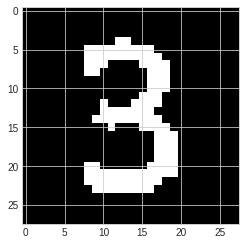

Model prediction: 3


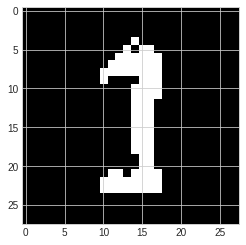

Model prediction: 3


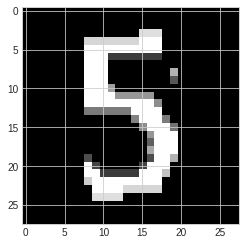

Model prediction: 5


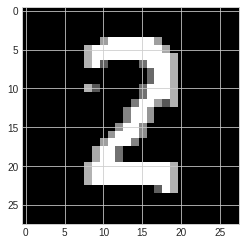

Model prediction: 2


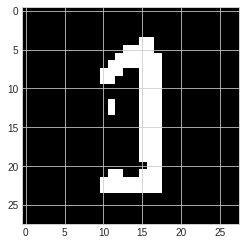

Model prediction: 1


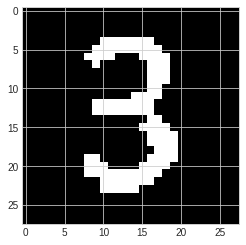

Model prediction: 3


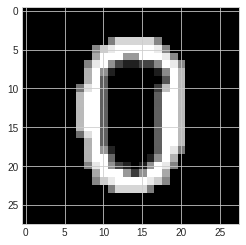

Model prediction: 0


In [127]:
# Predict single imagestf.convert_to_tensor(arg, dtype=tf.float32)
n_images = len(test)
images_test = np.zeros((n_images,784),dtype=object)
correct_vals = np.zeros((n_images,10))
i = 0
printImg = []
for no in range(n_images):
  img = np.zeros(test[i].shape, dtype=np.float32)
  img = test[i]
  H,W = img.shape
  pt = (28 - H)//2 if H < 28 else 0
  ps = (28 - W)//2
  tempImg = cv.copyMakeBorder(img,pt,pt,ps,ps, cv.BORDER_CONSTANT, value=0)
  gray = cv.resize(tempImg,(28,28))
  printImg += [gray]
  flatten = gray.flatten() / 255.0
  images_test[i] = np.float32(flatten)
  correct_val = np.zeros((10))
  correct_val[no] = 1
  correct_vals[i] = correct_val
  i += 1

test_images = mnist.test.images[:n_images]

for i in range(n_images):
  test_images[i] = images_test[i]

input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': test_images}, shuffle=False)
preds = list(model.predict(input_fn))

for i in range(n_images):
  plt.imshow(printImg[i], cmap='gray')
  plt.show()
  print("Model prediction:", preds[i])